# Torch Connector and Hybrid QNNs

This tutorial introduces the `TorchConnector` class, and demonstrates how it allows for a natural integration of any `NeuralNetwork` from Qiskit Machine Learning into a PyTorch workflow. `TorchConnector` takes a `NeuralNetwork` and makes it available as a PyTorch `Module`. The resulting module can be seamlessly incorporated into PyTorch classical architectures and trained jointly without additional considerations, enabling the development and testing of novel **hybrid quantum-classical** machine learning architectures.

## Content:

[Part 1: Simple Classification & Regression](#Part-1:-Simple-Classification-&-Regression)

The first part of this tutorial shows how quantum neural networks can be trained using PyTorch's automatic differentiation engine (`torch.autograd`, [link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)) for simple classification and regression tasks. 

1. [Classification](#1.-Classification)
    1. Classification with PyTorch and `EstimatorQNN`
    2. Classification with PyTorch and `SamplerQNN`
2. [Regression](#2.-Regression)
    1. Regression with PyTorch and `EstimatorQNN`

[Part 2: MNIST Classification, Hybrid QNNs](#Part-2:-MNIST-Classification,-Hybrid-QNNs)

The second part of this tutorial illustrates how to embed a (Quantum) `NeuralNetwork` into a target PyTorch workflow (in this case, a typical CNN architecture) to classify MNIST data in a hybrid quantum-classical manner.

***

In [1]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

## Part 1: Simple Classification & Regression

### 1. Classification

First, we show how `TorchConnector` allows to train a Quantum `NeuralNetwork` to solve a classification tasks using PyTorch's automatic differentiation engine. In order to illustrate this, we will perform **binary classification** on a randomly generated dataset.

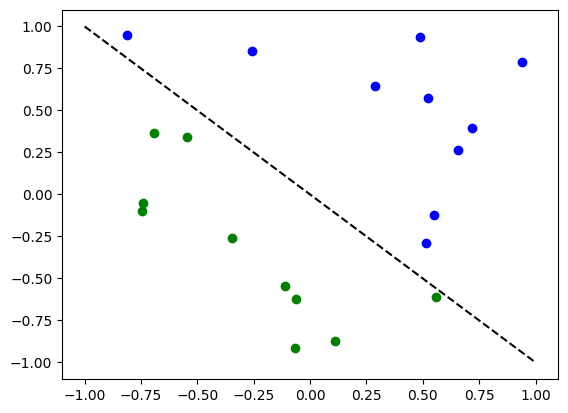

In [2]:
# Generate random dataset

# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for SamplerQNN example
y = 2 * y01 - 1  # in {-1, +1}, y will be used for EstimatorQNN example

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

#### A. Classification with PyTorch and  `EstimatorQNN`

Linking an `EstimatorQNN` to PyTorch is relatively straightforward. Here we illustrate this by using the `EstimatorQNN` constructed from a feature map and an ansatz.

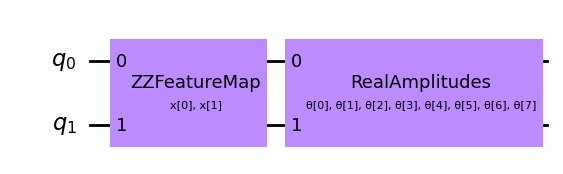

In [3]:
# Set up a circuit
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs)
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl", style="clifford")

In [4]:
# Setup QNN
qnn1 = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

# Set up PyTorch module
# Note: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

Initial weights:  [-0.01256962  0.06653564  0.04005302 -0.03752667  0.06645196  0.06095287
 -0.02250432 -0.04233438]


In [5]:
# Test with a single input
model1(X_[0, :])

tensor([-0.3285], grad_fn=<_TorchNNFunctionBackward>)

##### Optimizer
The choice of optimizer for training any machine learning model can be crucial in determining the success of our training's outcome. When using `TorchConnector`, we get access to all of the optimizer algorithms defined in the [`torch.optim`] package ([link](https://pytorch.org/docs/stable/optim.html)). Some of the most famous algorithms used in popular machine learning architectures include *Adam*, *SGD*, or *Adagrad*. However, for this tutorial we will be using the L-BFGS algorithm (`torch.optim.LBFGS`), one of the most well know second-order optimization algorithms for numerical optimization. 

##### Loss Function
As for the loss function, we can also take advantage of PyTorch's pre-defined modules from `torch.nn`, such as the [Cross-Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) or [Mean Squared Error](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) losses.


**💡 Clarification :** 
In classical machine learning, the general rule of thumb is to apply a Cross-Entropy loss to classification tasks, and MSE loss to regression tasks. However, this recommendation is given under the assumption that the output of the classification network is a class probability value in the $[0, 1]$ range (usually this is achieved  through a Softmax layer). Because the following example for `EstimatorQNN` does not include such layer, and we don't apply any mapping to the output (the following section shows an example of application of parity mapping with `SamplerQNN`s), the QNN's output can take any value in the range $[-1, 1]$. In case you were wondering, this is the reason why this particular example uses MSELoss for classification despite it not being the norm (but we encourage you to experiment with different loss functions and see how they can impact training results). 

In [6]:
# Define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model1.train()  # set model to training mode


# Note from (https://pytorch.org/docs/stable/optim.html):
# Some optimization algorithms such as LBFGS need to
# reevaluate the function multiple times, so you have to
# pass in a closure that allows them to recompute your model.
# The closure should clear the gradients, compute the loss,
# and return it.
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model1(X_), y_)  # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer step4
optimizer.step(closure)

25.535646438598633


22.696760177612305


20.039228439331055


19.68790626525879


19.267210006713867


19.025371551513672


18.154708862304688


17.33785629272461


19.082544326782227


17.07332420349121


16.21839141845703


14.992581367492676


14.929339408874512


14.914534568786621


14.907638549804688


14.902363777160645


14.902134895324707


14.90211009979248


14.902111053466797


tensor(25.5356, grad_fn=<MseLossBackward>)

Accuracy: 0.8


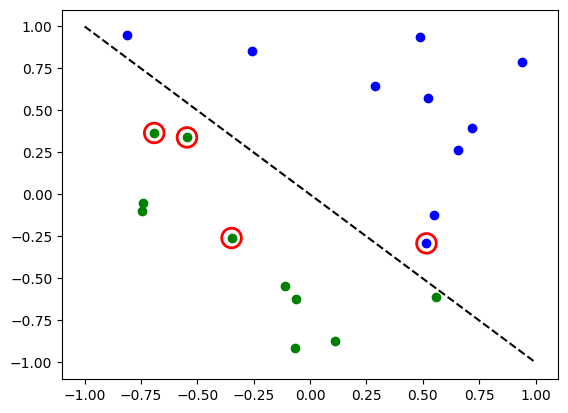

In [7]:
# Evaluate model and compute accuracy
model1.eval()
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print("Accuracy:", sum(y_predict == y) / len(y))

# Plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

The red circles indicate wrongly classified data points.

#### B. Classification with PyTorch and `SamplerQNN`

Linking a `SamplerQNN` to PyTorch requires a bit more attention than `EstimatorQNN`. Without the correct setup, backpropagation is not possible. 

In particular, we must make sure that we are returning a dense array of probabilities in the network's forward pass (`sparse=False`). This parameter is set up to `False` by default, so we just have to make sure that it has not been changed.

**⚠️ Attention:** 
If we define a custom interpret function ( in the example: `parity`), we must remember to explicitly provide the desired output shape ( in the example: `2`). For more info on the initial parameter setup for `SamplerQNN`, please check out the [official qiskit documentation](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html).

In [8]:
# Define feature map and ansatz
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement="linear", reps=1)

# Define quantum circuit of num_qubits = input dim
# Append feature map and ansatz
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Define SamplerQNN and initial setup
parity = lambda x: "{:b}".format(x).count("1") % 2  # optional interpret function
output_shape = 2  # parity = 0, 1
qnn2 = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn2.num_weights) - 1)
print("Initial weights: ", initial_weights)
model2 = TorchConnector(qnn2, initial_weights)

Initial weights:  [ 0.0364991  -0.0720495  -0.06001836 -0.09852755]


For a reminder on optimizer and loss function choices, you can go back to [this section](#Optimizer).

In [9]:
# Define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()  # Our output will be in the [0,1] range

# Start training
model2.train()

# Define LBFGS closure method (explained in previous section)
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model2(X_), y01_)  # Calculate loss
    loss.backward()  # Backward pass

    print(loss.item())  # Print loss
    return loss


# Run optimizer (LBFGS requires closure)
optimizer.step(closure);

0.6925069093704224


0.6881508231163025


0.65166836977005


0.6485998034477234


0.6394745707511902


0.7055025100708008


0.666935920715332


0.6768220663070679


0.6784337759017944


0.7485936284065247


0.6641563177108765


0.6561497449874878


0.66301429271698


0.6441987752914429


0.6511135697364807


0.628919243812561


0.6247060894966125


0.6366128921508789


0.6195870041847229


0.6179186105728149


Accuracy: 0.8


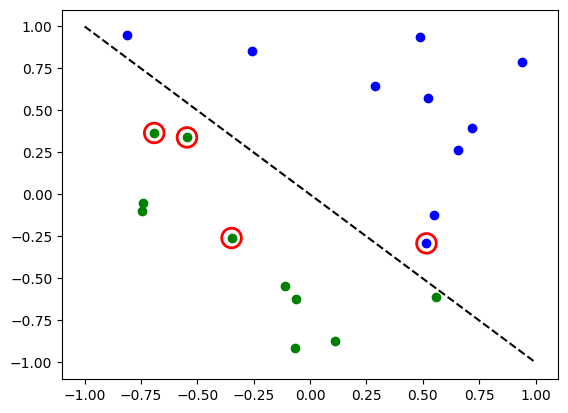

In [10]:
# Evaluate model and compute accuracy
model2.eval()
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print("Accuracy:", sum(y_predict == y01) / len(y01))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

The red circles indicate wrongly classified data points.

### 2. Regression 

We use a model based on the `EstimatorQNN` to also illustrate how to perform a regression task. The chosen dataset in this case is randomly generated following a sine wave. 

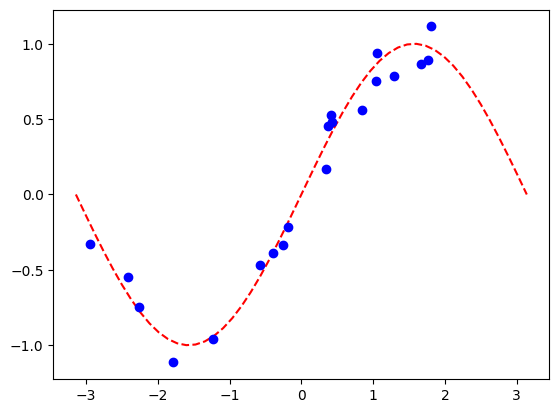

In [11]:
# Generate random dataset

num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X) + eps * (2 * algorithm_globals.random.random([num_samples, 1]) - 1)
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")
plt.plot(X, y, "bo")
plt.show()

#### A. Regression with PyTorch and `EstimatorQNN`

The network definition and training loop will be analogous to those of the classification task using `EstimatorQNN`. In this case, we define our own feature map and ansatz, but let's do it a little different.

In [12]:
# Construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# Construct simple parameterized ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

qc = QuantumCircuit(1)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Construct QNN
qnn3 = EstimatorQNN(circuit=qc, input_params=[param_x], weight_params=[param_y])

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn3.num_weights) - 1)
model3 = TorchConnector(qnn3, initial_weights)

For a reminder on optimizer and loss function choices, you can go back to [this section](#Optimizer).

In [13]:
# Define optimizer and loss function
optimizer = LBFGS(model3.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model3.train()  # set model to training mode

# Define objective function
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model3(Tensor(X)), Tensor(y))  # Compute batch loss
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer
optimizer.step(closure)

14.947757720947266
2.948650360107422
8.952412605285645
0.37905153632164
0.24995625019073486
0.2483610212802887
0.24835753440856934


tensor(14.9478, grad_fn=<MseLossBackward>)

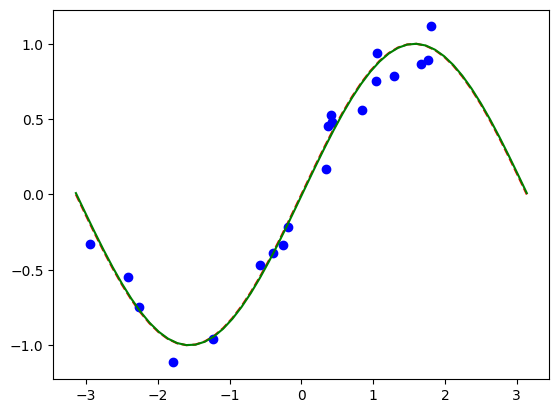

In [14]:
# Plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")

# Plot data
plt.plot(X, y, "bo")

# Plot fitted line
model3.eval()
y_ = []
for x in np.linspace(lb, ub):
    output = model3(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, "g-")
plt.show()

***

## Part 2: MNIST Classification, Hybrid QNNs

In this second part, we show how to leverage a hybrid quantum-classical neural network using `TorchConnector`, to perform a more complex image classification task on the MNIST handwritten digits dataset. 

For a more detailed (pre-`TorchConnector`) explanation on hybrid quantum-classical neural networks, you can check out the corresponding section in the [Qiskit Textbook repository](https://github.com/Qiskit/platypus/blob/main/notebooks/v2/ch-machine-learning/machine-learning-qiskit-pytorch.ipynb).

In [15]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

### Step 1: Defining Data-loaders for train and test

We take advantage of the `torchvision` [API](https://pytorch.org/vision/stable/datasets.html) to directly load a subset of the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) and define torch `DataLoader`s ([link](https://pytorch.org/docs/stable/data.html)) for train and test.

In [16]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

0.0%

0.0%

0.0%

0.0%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.4%

92.4%

92.4%

92.4%

92.4%

92.4%

92.4%

92.4%

92.4%

92.4%

92.5%

92.5%

92.5%

92.5%

92.5%

92.5%

92.5%

92.5%

92.5%

92.6%

92.6%

92.6%

92.6%

92.6%

92.6%

92.6%

92.6%

92.6%

92.6%

92.7%

92.7%

92.7%

92.7%

92.7%

92.7%

92.7%

92.7%

92.7%

92.7%

92.8%

92.8%

92.8%

92.8%

92.8%

92.8%

92.8%

92.8%

92.8%

92.9%

92.9%

92.9%

92.9%

92.9%

92.9%

92.9%

92.9%

92.9%

92.9%

93.0%

93.0%

93.0%

93.0%

93.0%

93.0%

93.0%

93.0%

93.0%

93.0%

93.1%

93.1%

93.1%

93.1%

93.1%

93.1%

93.1%

93.1%

93.1%

93.1%

93.2%

93.2%

93.2%

93.2%

93.2%

93.2%

93.2%

93.2%

93.2%

93.3%

93.3%

93.3%

93.3%

93.3%

93.3%

93.3%

93.3%

93.3%

93.3%

93.4%

93.4%

93.4%

93.4%

93.4%

93.4%

93.4%

93.4%

93.4%

93.4%

93.5%

93.5%

93.5%

93.5%

93.5%

93.5%

93.5%

93.5%

93.5%

93.6%

93.6%

93.6%

93.6%

93.6%

93.6%

93.6%

93.6%

93.6%

93.6%

93.7%

93.7%

93.7%

93.7%

93.7%

93.7%

93.7%

93.7%

93.7%

93.7%

93.8%

93.8%

93.8%

93.8%

93.8%

93.8%

93.8%

93.8%

93.8%

93.9%

93.9%

93.9%

93.9%

93.9%

93.9%

93.9%

93.9%

93.9%

93.9%

94.0%

94.0%

94.0%

94.0%

94.0%

94.0%

94.0%

94.0%

94.0%

94.0%

94.1%

94.1%

94.1%

94.1%

94.1%

94.1%

94.1%

94.1%

94.1%

94.2%

94.2%

94.2%

94.2%

94.2%

94.2%

94.2%

94.2%

94.2%

94.2%

94.3%

94.3%

94.3%

94.3%

94.3%

94.3%

94.3%

94.3%

94.3%

94.3%

94.4%

94.4%

94.4%

94.4%

94.4%

94.4%

94.4%

94.4%

94.4%

94.5%

94.5%

94.5%

94.5%

94.5%

94.5%

94.5%

94.5%

94.5%

94.5%

94.6%

94.6%

94.6%

94.6%

94.6%

94.6%

94.6%

94.6%

94.6%

94.6%

94.7%

94.7%

94.7%

94.7%

94.7%

94.7%

94.7%

94.7%

94.7%

94.8%

94.8%

94.8%

94.8%

94.8%

94.8%

94.8%

94.8%

94.8%

94.8%

94.9%

94.9%

94.9%

94.9%

94.9%

94.9%

94.9%

94.9%

94.9%

94.9%

95.0%

95.0%

95.0%

95.0%

95.0%

95.0%

95.0%

95.0%

95.0%

95.1%

95.1%

95.1%

95.1%

95.1%

95.1%

95.1%

95.1%

95.1%

95.1%

95.2%

95.2%

95.2%

95.2%

95.2%

95.2%

95.2%

95.2%

95.2%

95.2%

95.3%

95.3%

95.3%

95.3%

95.3%

95.3%

95.3%

95.3%

95.3%

95.4%

95.4%

95.4%

95.4%

95.4%

95.4%

95.4%

95.4%

95.4%

95.4%

95.5%

95.5%

95.5%

95.5%

95.5%

95.5%

95.5%

95.5%

95.5%

95.5%

95.6%

95.6%

95.6%

95.6%

95.6%

95.6%

95.6%

95.6%

95.6%

95.6%

95.7%

95.7%

95.7%

95.7%

95.7%

95.7%

95.7%

95.7%

95.7%

95.8%

95.8%

95.8%

95.8%

95.8%

95.8%

95.8%

95.8%

95.8%

95.8%

95.9%

95.9%

95.9%

95.9%

95.9%

95.9%

95.9%

95.9%

95.9%

95.9%

96.0%

96.0%

96.0%

96.0%

96.0%

96.0%

96.0%

96.0%

96.0%

96.1%

96.1%

96.1%

96.1%

96.1%

96.1%

96.1%

96.1%

96.1%

96.1%

96.2%

96.2%

96.2%

96.2%

96.2%

96.2%

96.2%

96.2%

96.2%

96.2%

96.3%

96.3%

96.3%

96.3%

96.3%

96.3%

96.3%

96.3%

96.3%

96.4%

96.4%

96.4%

96.4%

96.4%

96.4%

96.4%

96.4%

96.4%

96.4%

96.5%

96.5%

96.5%

96.5%

96.5%

96.5%

96.5%

96.5%

96.5%

96.5%

96.6%

96.6%

96.6%

96.6%

96.6%

96.6%

96.6%

96.6%

96.6%

96.7%

96.7%

96.7%

96.7%

96.7%

96.7%

96.7%

96.7%

96.7%

96.7%

96.8%

96.8%

96.8%

96.8%

96.8%

96.8%

96.8%

96.8%

96.8%

96.8%

96.9%

96.9%

96.9%

96.9%

96.9%

96.9%

96.9%

96.9%

96.9%

97.0%

97.0%

97.0%

97.0%

97.0%

97.0%

97.0%

97.0%

97.0%

97.0%

97.1%

97.1%

97.1%

97.1%

97.1%

97.1%

97.1%

97.1%

97.1%

97.1%

97.2%

97.2%

97.2%

97.2%

97.2%

97.2%

97.2%

97.2%

97.2%

97.3%

97.3%

97.3%

97.3%

97.3%

97.3%

97.3%

97.3%

97.3%

97.3%

97.4%

97.4%

97.4%

97.4%

97.4%

97.4%

97.4%

97.4%

97.4%

97.4%

97.5%

97.5%

97.5%

97.5%

97.5%

97.5%

97.5%

97.5%

97.5%

97.6%

97.6%

97.6%

97.6%

97.6%

97.6%

97.6%

97.6%

97.6%

97.6%

97.7%

97.7%

97.7%

97.7%

97.7%

97.7%

97.7%

97.7%

97.7%

97.7%

97.8%

97.8%

97.8%

97.8%

97.8%

97.8%

97.8%

97.8%

97.8%

97.9%

97.9%

97.9%

97.9%

97.9%

97.9%

97.9%

97.9%

97.9%

97.9%

98.0%

98.0%

98.0%

98.0%

98.0%

98.0%

98.0%

98.0%

98.0%

98.0%

98.1%

98.1%

98.1%

98.1%

98.1%

98.1%

98.1%

98.1%

98.1%

98.1%

98.2%

98.2%

98.2%

98.2%

98.2%

98.2%

98.2%

98.2%

98.2%

98.3%

98.3%

98.3%

98.3%

98.3%

98.3%

98.3%

98.3%

98.3%

98.3%

98.4%

98.4%

98.4%

98.4%

98.4%

98.4%

98.4%

98.4%

98.4%

98.4%

98.5%

98.5%

98.5%

98.5%

98.5%

98.5%

98.5%

98.5%

98.5%

98.6%

98.6%

98.6%

98.6%

98.6%

98.6%

98.6%

98.6%

98.6%

98.6%

98.7%

98.7%

98.7%

98.7%

98.7%

98.7%

98.7%

98.7%

98.7%

98.7%

98.8%

98.8%

98.8%

98.8%

98.8%

98.8%

98.8%

98.8%

98.8%

98.9%

98.9%

98.9%

98.9%

98.9%

98.9%

98.9%

98.9%

98.9%

98.9%

99.0%

99.0%

99.0%

99.0%

99.0%

99.0%

99.0%

99.0%

99.0%

99.0%

99.1%

99.1%

99.1%

99.1%

99.1%

99.1%

99.1%

99.1%

99.1%

99.2%

99.2%

99.2%

99.2%

99.2%

99.2%

99.2%

99.2%

99.2%

99.2%

99.3%

99.3%

99.3%

99.3%

99.3%

99.3%

99.3%

99.3%

99.3%

99.3%

99.4%

99.4%

99.4%

99.4%

99.4%

99.4%

99.4%

99.4%

99.4%

99.5%

99.5%

99.5%

99.5%

99.5%

99.5%

99.5%

99.5%

99.5%

99.5%

99.6%

99.6%

99.6%

99.6%

99.6%

99.6%

99.6%

99.6%

99.6%

99.6%

99.7%

99.7%

99.7%

99.7%

99.7%

99.7%

99.7%

99.7%

99.7%

99.8%

99.8%

99.8%

99.8%

99.8%

99.8%

99.8%

99.8%

99.8%

99.8%

99.9%

99.9%

99.9%

99.9%

99.9%

99.9%

99.9%

99.9%

99.9%

99.9%

100.0%

100.0%

100.0%

100.0%

100.0%

100.0%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


3.5%

7.1%

10.6%

14.2%

17.7%

21.3%

24.8%

28.4%

31.9%

35.5%

39.0%

42.5%

46.1%

49.6%

53.2%

56.7%

60.3%

63.8%

67.4%

70.9%

74.5%

78.0%

81.5%

85.1%

88.6%

92.2%

95.7%

99.3%

102.8%


0.1%

0.1%

0.2%

0.2%

0.3%

0.4%

0.4%

0.5%

0.6%

0.6%

0.7%

0.7%

0.8%

0.9%

0.9%

1.0%

1.1%

1.1%

1.2%

1.2%

1.3%

1.4%

1.4%

1.5%

1.6%

1.6%

1.7%

1.7%

1.8%

1.9%

1.9%

2.0%

2.0%

2.1%

2.2%

2.2%

2.3%

2.4%

2.4%

2.5%

2.5%

2.6%

2.7%

2.7%

2.8%

2.9%

2.9%

3.0%

3.0%

3.1%

3.2%

3.2%

3.3%

3.4%

3.4%

3.5%

3.5%

3.6%

3.7%

3.7%

3.8%

3.9%

3.9%

4.0%

4.0%

4.1%

4.2%

4.2%

4.3%

4.3%

4.4%

4.5%

4.5%

4.6%

4.7%

4.7%

4.8%

4.8%

4.9%

5.0%

5.0%

5.1%

5.2%

5.2%

5.3%

5.3%

5.4%

5.5%

5.5%

5.6%

5.7%

5.7%

5.8%

5.8%

5.9%

6.0%

6.0%

6.1%

6.1%

6.2%

6.3%

6.3%

6.4%

6.5%

6.5%

6.6%

6.6%

6.7%

6.8%

6.8%

6.9%

7.0%

7.0%

7.1%

7.1%

7.2%

7.3%

7.3%

7.4%

7.5%

7.5%

7.6%

7.6%

7.7%

7.8%

7.8%

7.9%

7.9%

8.0%

8.1%

8.1%

8.2%

8.3%

8.3%

8.4%

8.4%

8.5%

8.6%

8.6%

8.7%

8.8%

8.8%

8.9%

8.9%

9.0%

9.1%

9.1%

9.2%

9.3%

9.3%

9.4%

9.4%

9.5%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



9.6%

9.6%

9.7%

9.8%

9.8%

9.9%

9.9%

10.0%

10.1%

10.1%

10.2%

10.2%

10.3%

10.4%

10.4%

10.5%

10.6%

10.6%

10.7%

10.7%

10.8%

10.9%

10.9%

11.0%

11.1%

11.1%

11.2%

11.2%

11.3%

11.4%

11.4%

11.5%

11.6%

11.6%

11.7%

11.7%

11.8%

11.9%

11.9%

12.0%

12.0%

12.1%

12.2%

12.2%

12.3%

12.4%

12.4%

12.5%

12.5%

12.6%

12.7%

12.7%

12.8%

12.9%

12.9%

13.0%

13.0%

13.1%

13.2%

13.2%

13.3%

13.4%

13.4%

13.5%

13.5%

13.6%

13.7%

13.7%

13.8%

13.8%

13.9%

14.0%

14.0%

14.1%

14.2%

14.2%

14.3%

14.3%

14.4%

14.5%

14.5%

14.6%

14.7%

14.7%

14.8%

14.8%

14.9%

15.0%

15.0%

15.1%

15.2%

15.2%

15.3%

15.3%

15.4%

15.5%

15.5%

15.6%

15.6%

15.7%

15.8%

15.8%

15.9%

16.0%

16.0%

16.1%

16.1%

16.2%

16.3%

16.3%

16.4%

16.5%

16.5%

16.6%

16.6%

16.7%

16.8%

16.8%

16.9%

17.0%

17.0%

17.1%

17.1%

17.2%

17.3%

17.3%

17.4%

17.5%

17.5%

17.6%

17.6%

17.7%

17.8%

17.8%

17.9%

17.9%

18.0%

18.1%

18.1%

18.2%

18.3%

18.3%

18.4%

18.4%

18.5%

18.6%

18.6%

18.7%

18.8%

18.8%

18.9%

18.9%

19.0%

19.1%

19.1%

19.2%

19.3%

19.3%

19.4%

19.4%

19.5%

19.6%

19.6%

19.7%

19.7%

19.8%

19.9%

19.9%

20.0%

20.1%

20.1%

20.2%

20.2%

20.3%

20.4%

20.4%

20.5%

20.6%

20.6%

20.7%

20.7%

20.8%

20.9%

20.9%

21.0%

21.1%

21.1%

21.2%

21.2%

21.3%

21.4%

21.4%

21.5%

21.5%

21.6%

21.7%

21.7%

21.8%

21.9%

21.9%

22.0%

22.0%

22.1%

22.2%

22.2%

22.3%

22.4%

22.4%

22.5%

22.5%

22.6%

22.7%

22.7%

22.8%

22.9%

22.9%

23.0%

23.0%

23.1%

23.2%

23.2%

23.3%

23.4%

23.4%

23.5%

23.5%

23.6%

23.7%

23.7%

23.8%

23.8%

23.9%

24.0%

24.0%

24.1%

24.2%

24.2%

24.3%

24.3%

24.4%

24.5%

24.5%

24.6%

24.7%

24.7%

24.8%

24.8%

24.9%

25.0%

25.0%

25.1%

25.2%

25.2%

25.3%

25.3%

25.4%

25.5%

25.5%

25.6%

25.6%

25.7%

25.8%

25.8%

25.9%

26.0%

26.0%

26.1%

26.1%

26.2%

26.3%

26.3%

26.4%

26.5%

26.5%

26.6%

26.6%

26.7%

26.8%

26.8%

26.9%

27.0%

27.0%

27.1%

27.1%

27.2%

27.3%

27.3%

27.4%

27.4%

27.5%

27.6%

27.6%

27.7%

27.8%

27.8%

27.9%

27.9%

28.0%

28.1%

28.1%

28.2%

28.3%

28.3%

28.4%

28.4%

28.5%

28.6%

28.6%

28.7%

28.8%

28.8%

28.9%

28.9%

29.0%

29.1%

29.1%

29.2%

29.3%

29.3%

29.4%

29.4%

29.5%

29.6%

29.6%

29.7%

29.7%

29.8%

29.9%

29.9%

30.0%

30.1%

30.1%

30.2%

30.2%

30.3%

30.4%

30.4%

30.5%

30.6%

30.6%

30.7%

30.7%

30.8%

30.9%

30.9%

31.0%

31.1%

31.1%

31.2%

31.2%

31.3%

31.4%

31.4%

31.5%

31.5%

31.6%

31.7%

31.7%

31.8%

31.9%

31.9%

32.0%

32.0%

32.1%

32.2%

32.2%

32.3%

32.4%

32.4%

32.5%

32.5%

32.6%

32.7%

32.7%

32.8%

32.9%

32.9%

33.0%

33.0%

33.1%

33.2%

33.2%

33.3%

33.3%

33.4%

33.5%

33.5%

33.6%

33.7%

33.7%

33.8%

33.8%

33.9%

34.0%

34.0%

34.1%

34.2%

34.2%

34.3%

34.3%

34.4%

34.5%

34.5%

34.6%

34.7%

34.7%

34.8%

34.8%

34.9%

35.0%

35.0%

35.1%

35.2%

35.2%

35.3%

35.3%

35.4%

35.5%

35.5%

35.6%

35.6%

35.7%

35.8%

35.8%

35.9%

36.0%

36.0%

36.1%

36.1%

36.2%

36.3%

36.3%

36.4%

36.5%

36.5%

36.6%

36.6%

36.7%

36.8%

36.8%

36.9%

37.0%

37.0%

37.1%

37.1%

37.2%

37.3%

37.3%

37.4%

37.4%

37.5%

37.6%

37.6%

37.7%

37.8%

37.8%

37.9%

37.9%

38.0%

38.1%

38.1%

38.2%

38.3%

38.3%

38.4%

38.4%

38.5%

38.6%

38.6%

38.7%

38.8%

38.8%

38.9%

38.9%

39.0%

39.1%

39.1%

39.2%

39.2%

39.3%

39.4%

39.4%

39.5%

39.6%

39.6%

39.7%

39.7%

39.8%

39.9%

39.9%

40.0%

40.1%

40.1%

40.2%

40.2%

40.3%

40.4%

40.4%

40.5%

40.6%

40.6%

40.7%

40.7%

40.8%

40.9%

40.9%

41.0%

41.0%

41.1%

41.2%

41.2%

41.3%

41.4%

41.4%

41.5%

41.5%

41.6%

41.7%

41.7%

41.8%

41.9%

41.9%

42.0%

42.0%

42.1%

42.2%

42.2%

42.3%

42.4%

42.4%

42.5%

42.5%

42.6%

42.7%

42.7%

42.8%

42.9%

42.9%

43.0%

43.0%

43.1%

43.2%

43.2%

43.3%

43.3%

43.4%

43.5%

43.5%

43.6%

43.7%

43.7%

43.8%

43.8%

43.9%

44.0%

44.0%

44.1%

44.2%

44.2%

44.3%

44.3%

44.4%

44.5%

44.5%

44.6%

44.7%

44.7%

44.8%

44.8%

44.9%

45.0%

45.0%

45.1%

45.1%

45.2%

45.3%

45.3%

45.4%

45.5%

45.5%

45.6%

45.6%

45.7%

45.8%

45.8%

45.9%

46.0%

46.0%

46.1%

46.1%

46.2%

46.3%

46.3%

46.4%

46.5%

46.5%

46.6%

46.6%

46.7%

46.8%

46.8%

46.9%

46.9%

47.0%

47.1%

47.1%

47.2%

47.3%

47.3%

47.4%

47.4%

47.5%

47.6%

47.6%

47.7%

47.8%

47.8%

47.9%

47.9%

48.0%

48.1%

48.1%

48.2%

48.3%

48.3%

48.4%

48.4%

48.5%

48.6%

48.6%

48.7%

48.8%

48.8%

48.9%

48.9%

49.0%

49.1%

49.1%

49.2%

49.2%

49.3%

49.4%

49.4%

49.5%

49.6%

49.6%

49.7%

49.7%

49.8%

49.9%

49.9%

50.0%

50.1%

50.1%

50.2%

50.2%

50.3%

50.4%

50.4%

50.5%

50.6%

50.6%

50.7%

50.7%

50.8%

50.9%

50.9%

51.0%

51.0%

51.1%

51.2%

51.2%

51.3%

51.4%

51.4%

51.5%

51.5%

51.6%

51.7%

51.7%

51.8%

51.9%

51.9%

52.0%

52.0%

52.1%

52.2%

52.2%

52.3%

52.4%

52.4%

52.5%

52.5%

52.6%

52.7%

52.7%

52.8%

52.8%

52.9%

53.0%

53.0%

53.1%

53.2%

53.2%

53.3%

53.3%

53.4%

53.5%

53.5%

53.6%

53.7%

53.7%

53.8%

53.8%

53.9%

54.0%

54.0%

54.1%

54.2%

54.2%

54.3%

54.3%

54.4%

54.5%

54.5%

54.6%

54.7%

54.7%

54.8%

54.8%

54.9%

55.0%

55.0%

55.1%

55.1%

55.2%

55.3%

55.3%

55.4%

55.5%

55.5%

55.6%

55.6%

55.7%

55.8%

55.8%

55.9%

56.0%

56.0%

56.1%

56.1%

56.2%

56.3%

56.3%

56.4%

56.5%

56.5%

56.6%

56.6%

56.7%

56.8%

56.8%

56.9%

56.9%

57.0%

57.1%

57.1%

57.2%

57.3%

57.3%

57.4%

57.4%

57.5%

57.6%

57.6%

57.7%

57.8%

57.8%

57.9%

57.9%

58.0%

58.1%

58.1%

58.2%

58.3%

58.3%

58.4%

58.4%

58.5%

58.6%

58.6%

58.7%

58.7%

58.8%

58.9%

58.9%

59.0%

59.1%

59.1%

59.2%

59.2%

59.3%

59.4%

59.4%

59.5%

59.6%

59.6%

59.7%

59.7%

59.8%

59.9%

59.9%

60.0%

60.1%

60.1%

60.2%

60.2%

60.3%

60.4%

60.4%

60.5%

60.6%

60.6%

60.7%

60.7%

60.8%

60.9%

60.9%

61.0%

61.0%

61.1%

61.2%

61.2%

61.3%

61.4%

61.4%

61.5%

61.5%

61.6%

61.7%

61.7%

61.8%

61.9%

61.9%

62.0%

62.0%

62.1%

62.2%

62.2%

62.3%

62.4%

62.4%

62.5%

62.5%

62.6%

62.7%

62.7%

62.8%

62.8%

62.9%

63.0%

63.0%

63.1%

63.2%

63.2%

63.3%

63.3%

63.4%

63.5%

63.5%

63.6%

63.7%

63.7%

63.8%

63.8%

63.9%

64.0%

64.0%

64.1%

64.2%

64.2%

64.3%

64.3%

64.4%

64.5%

64.5%

64.6%

64.6%

64.7%

64.8%

64.8%

64.9%

65.0%

65.0%

65.1%

65.1%

65.2%

65.3%

65.3%

65.4%

65.5%

65.5%

65.6%

65.6%

65.7%

65.8%

65.8%

65.9%

66.0%

66.0%

66.1%

66.1%

66.2%

66.3%

66.3%

66.4%

66.5%

66.5%

66.6%

66.6%

66.7%

66.8%

66.8%

66.9%

66.9%

67.0%

67.1%

67.1%

67.2%

67.3%

67.3%

67.4%

67.4%

67.5%

67.6%

67.6%

67.7%

67.8%

67.8%

67.9%

67.9%

68.0%

68.1%

68.1%

68.2%

68.3%

68.3%

68.4%

68.4%

68.5%

68.6%

68.6%

68.7%

68.7%

68.8%

68.9%

68.9%

69.0%

69.1%

69.1%

69.2%

69.2%

69.3%

69.4%

69.4%

69.5%

69.6%

69.6%

69.7%

69.7%

69.8%

69.9%

69.9%

70.0%

70.1%

70.1%

70.2%

70.2%

70.3%

70.4%

70.4%

70.5%

70.5%

70.6%

70.7%

70.7%

70.8%

70.9%

70.9%

71.0%

71.0%

71.1%

71.2%

71.2%

71.3%

71.4%

71.4%

71.5%

71.5%

71.6%

71.7%

71.7%

71.8%

71.9%

71.9%

72.0%

72.0%

72.1%

72.2%

72.2%

72.3%

72.3%

72.4%

72.5%

72.5%

72.6%

72.7%

72.7%

72.8%

72.8%

72.9%

73.0%

73.0%

73.1%

73.2%

73.2%

73.3%

73.3%

73.4%

73.5%

73.5%

73.6%

73.7%

73.7%

73.8%

73.8%

73.9%

74.0%

74.0%

74.1%

74.2%

74.2%

74.3%

74.3%

74.4%

74.5%

74.5%

74.6%

74.6%

74.7%

74.8%

74.8%

74.9%

75.0%

75.0%

75.1%

75.1%

75.2%

75.3%

75.3%

75.4%

75.5%

75.5%

75.6%

75.6%

75.7%

75.8%

75.8%

75.9%

76.0%

76.0%

76.1%

76.1%

76.2%

76.3%

76.3%

76.4%

76.4%

76.5%

76.6%

76.6%

76.7%

76.8%

76.8%

76.9%

76.9%

77.0%

77.1%

77.1%

77.2%

77.3%

77.3%

77.4%

77.4%

77.5%

77.6%

77.6%

77.7%

77.8%

77.8%

77.9%

77.9%

78.0%

78.1%

78.1%

78.2%

78.2%

78.3%

78.4%

78.4%

78.5%

78.6%

78.6%

78.7%

78.7%

78.8%

78.9%

78.9%

79.0%

79.1%

79.1%

79.2%

79.2%

79.3%

79.4%

79.4%

79.5%

79.6%

79.6%

79.7%

79.7%

79.8%

79.9%

79.9%

80.0%

80.1%

80.1%

80.2%

80.2%

80.3%

80.4%

80.4%

80.5%

80.5%

80.6%

80.7%

80.7%

80.8%

80.9%

80.9%

81.0%

81.0%

81.1%

81.2%

81.2%

81.3%

81.4%

81.4%

81.5%

81.5%

81.6%

81.7%

81.7%

81.8%

81.9%

81.9%

82.0%

82.0%

82.1%

82.2%

82.2%

82.3%

82.3%

82.4%

82.5%

82.5%

82.6%

82.7%

82.7%

82.8%

82.8%

82.9%

83.0%

83.0%

83.1%

83.2%

83.2%

83.3%

83.3%

83.4%

83.5%

83.5%

83.6%

83.7%

83.7%

83.8%

83.8%

83.9%

84.0%

84.0%

84.1%

84.1%

84.2%

84.3%

84.3%

84.4%

84.5%

84.5%

84.6%

84.6%

84.7%

84.8%

84.8%

84.9%

85.0%

85.0%

85.1%

85.1%

85.2%

85.3%

85.3%

85.4%

85.5%

85.5%

85.6%

85.6%

85.7%

85.8%

85.8%

85.9%

86.0%

86.0%

86.1%

86.1%

86.2%

86.3%

86.3%

86.4%

86.4%

86.5%

86.6%

86.6%

86.7%

86.8%

86.8%

86.9%

86.9%

87.0%

87.1%

87.1%

87.2%

87.3%

87.3%

87.4%

87.4%

87.5%

87.6%

87.6%

87.7%

87.8%

87.8%

87.9%

87.9%

88.0%

88.1%

88.1%

88.2%

88.2%

88.3%

88.4%

88.4%

88.5%

88.6%

88.6%

88.7%

88.7%

88.8%

88.9%

88.9%

89.0%

89.1%

89.1%

89.2%

89.2%

89.3%

89.4%

89.4%

89.5%

89.6%

89.6%

89.7%

89.7%

89.8%

89.9%

89.9%

90.0%

90.0%

90.1%

90.2%

90.2%

90.3%

90.4%

90.4%

90.5%

90.5%

90.6%

90.7%

90.7%

90.8%

90.9%

90.9%

91.0%

91.0%

91.1%

91.2%

91.2%

91.3%

91.4%

91.4%

91.5%

91.5%

91.6%

91.7%

91.7%

91.8%

91.9%

91.9%

92.0%

92.0%

92.1%

92.2%

92.2%

92.3%

92.3%

92.4%

92.5%

92.5%

92.6%

92.7%

92.7%

92.8%

92.8%

92.9%

93.0%

93.0%

93.1%

93.2%

93.2%

93.3%

93.3%

93.4%

93.5%

93.5%

93.6%

93.7%

93.7%

93.8%

93.8%

93.9%

94.0%

94.0%

94.1%

94.1%

94.2%

94.3%

94.3%

94.4%

94.5%

94.5%

94.6%

94.6%

94.7%

94.8%

94.8%

94.9%

95.0%

95.0%

95.1%

95.1%

95.2%

95.3%

95.3%

95.4%

95.5%

95.5%

95.6%

95.6%

95.7%

95.8%

95.8%

95.9%

95.9%

96.0%

96.1%

96.1%

96.2%

96.3%

96.3%

96.4%

96.4%

96.5%

96.6%

96.6%

96.7%

96.8%

96.8%

96.9%

96.9%

97.0%

97.1%

97.1%

97.2%

97.3%

97.3%

97.4%

97.4%

97.5%

97.6%

97.6%

97.7%

97.7%

97.8%

97.9%

97.9%

98.0%

98.1%

98.1%

98.2%

98.2%

98.3%

98.4%

98.4%

98.5%

98.6%

98.6%

98.7%

98.7%

98.8%

98.9%

98.9%

99.0%

99.1%

99.1%

99.2%

99.2%

99.3%

99.4%

99.4%

99.5%

99.6%

99.6%

99.7%

99.7%

99.8%

99.9%

99.9%

100.0%

100.0%

22.5%

45.1%

67.6%

90.2%

112.7%

/opt/hostedtoolcache/Python/3.8.18/x64/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...


Done!


If we perform a quick visualization we can see that the train dataset consists of images of handwritten 0s and 1s.

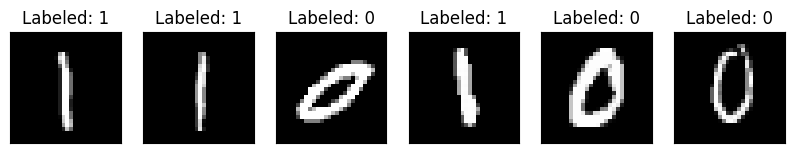

In [17]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [18]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

### Step 2: Defining the QNN and Hybrid Model

This second step shows the power of the `TorchConnector`. After defining our quantum neural network layer (in this case, a `EstimatorQNN`), we can embed it into a layer in our torch `Module` by initializing a torch connector as `TorchConnector(qnn)`.

**⚠️ Attention:**
In order to have an adequate gradient backpropagation in hybrid models,  we MUST set the initial parameter `input_gradients` to TRUE during the qnn initialization.

In [19]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [20]:
# Define torch NN module


class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

### Step 3: Training

In [21]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -0.5145


Training [20%]	Loss: -0.5379


Training [30%]	Loss: -0.5987


Training [40%]	Loss: -0.8502


Training [50%]	Loss: -1.1294


Training [60%]	Loss: -1.3782


Training [70%]	Loss: -1.6121


Training [80%]	Loss: -1.8341


Training [90%]	Loss: -2.1130


Training [100%]	Loss: -2.3251


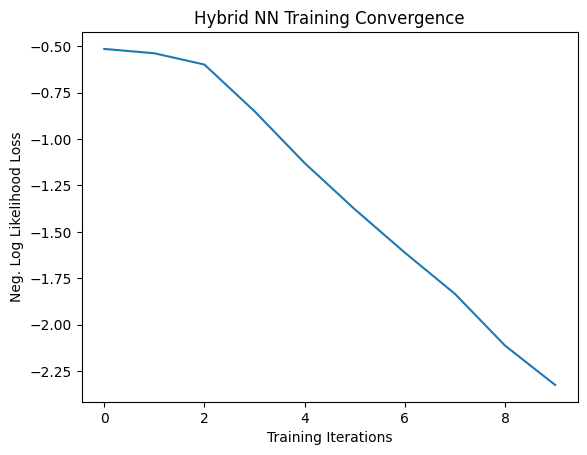

In [22]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

Now we'll save the trained model, just to show how a hybrid model can be saved and re-used later for inference. To save and load hybrid models, when using the TorchConnector, follow the PyTorch recommendations of saving and loading the models.

In [23]:
torch.save(model4.state_dict(), "model4.pt")

### Step 4: Evaluation

We start from recreating the model and loading the state from the previously saved file. You create a QNN layer using another simulator or a real hardware. So, you can train a model on real hardware available on the cloud and then for inference use a simulator or vice verse. For a sake of simplicity we create a new quantum neural network in the same way as above.

In [24]:
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

<All keys matched successfully>

In [25]:
model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: -2.3104
	Accuracy: 98.0%


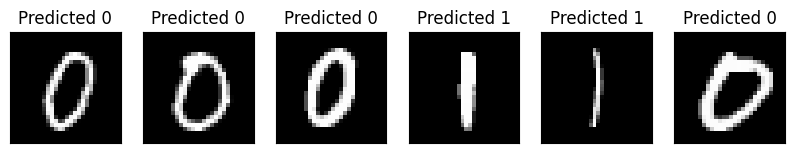

In [26]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

🎉🎉🎉🎉
**You are now able to experiment with your own hybrid datasets and architectures using Qiskit Machine Learning.** 
**Good Luck!**

In [27]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright